<a href="https://colab.research.google.com/github/spazznolo/goalie-consistency/blob/main/dsf_stc_exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import pandas as pd
import numpy as np
import re, string
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# **Exploring the Dataset**

Outside of the target, which is binary (Disaster or not), all other relevant variables are characters. The main variable is the tweet itself, in the 'text' variable. Outside of that, there is a keyword variable (available for all but 0.8% of tweets) and a location variable (available for 66.7% of tweets).

In [4]:
train.isnull().mean(axis = 0)

id          0.000000
keyword     0.008013
location    0.332720
text        0.000000
target      0.000000
dtype: float64

#**Pre-processing Ideas**

It is important to understand the context of the text being analyzed before deciding on the pre-processing steps. This analysis involves public, short-form communication on the popular social media website Twitter through the form of Tweets. There are textual patterns which are particular to Twitter, such as:


*   Mentions (@username)
*   Hashtags (#subject)
*   Retweets 



In [5]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [6]:
X = train.drop(['target'], axis=1)
y = train['target']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=33)

# **Task 1: Bag of words model**

The first model, which is also the simplest, is built through the text processing method called Bag-of-Words, where the number of occurences of a given word 

In [7]:
# define a function to remove character references (e.g., &lt;, &amp;, &nbsp;)
def preprocess_text(text):
    text = re.sub(r'&[a-zA-Z]+;?', '', text)
    text = re.sub(r'@[a-zA-Z_]+;?', '', text)
    text = re.sub(r'\w*\d+\w*', '', text)
    return text

# remove character references
X_train['text'] = X_train['text'].apply(preprocess_text)
X_val['text'] = X_val['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

In [8]:
vectorizer = CountVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train['text'])
X_train_vec = pd.DataFrame(X_train_vec.toarray(), columns=vectorizer.get_feature_names_out(), index=X_train.index)

X_val_vec = vectorizer.transform(X_val['text'])
X_val_vec = pd.DataFrame(X_val_vec.toarray(), columns=vectorizer.get_feature_names_out(), index=X_val.index)

In [9]:
# Create an instance of LogisticRegression classifier
lr = LogisticRegression(random_state=1)
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_val_vec)
  
# Use metrics.accuracy_score to measure the score
precision = precision_score(y_val, y_pred)
fscore = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

In [10]:
print(precision, fscore, accuracy)

0.8290854572713643 0.7339084273390843 0.789390756302521


In [11]:
# import TfidfVectorizer

# instantiate the vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,1), stop_words='english')

# fit and transform
X_train_tfidf = tfidf.fit_transform(X_train['text'])
X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray(), columns = tfidf.get_feature_names_out(), index=X_train.index)

# fit and transform
X_val_tfidf = tfidf.transform(X_val['text'])
X_val_tfidf = pd.DataFrame(X_val_tfidf.toarray(), columns = tfidf.get_feature_names_out(), index=X_val.index)

# **Mining Other Predictors**

Twitter is used for a wide variety of purposes. It is used to disseminate official information to the populace, to debate and discuss rapidly evolving news stories, for the creation/dissemination of art, for entertainment among friends. Through all of these use case, the communication tends to have unique stylistic choices. As an example, official information maybe be written more formally, with care taken to follow linguistic conventions, whereas informal communication among friends maybe be shorter and less conventional. It is along these lines of thought that the following predictors were created.


*   Tweet length (number of characters in Tweet)
*   Average Word Length (not counting stop words)
*   Location (binary, location of person when they Tweeted)
*   Hashtags (integer, usually used to contribute to a current trend)
*   Keyword (binary, seems to be pulled directly from tweet)




In [12]:
X_train_tfidf['keyword_binary'] = np.where(X_train['keyword'].isnull(), 0, 1)
X_val_tfidf['keyword_binary'] = np.where(X_val['keyword'].isnull(), 0, 1)

X_train_tfidf['location_binary'] = np.where(X_train['location'].isnull(), 0, 1)
X_val_tfidf['location_binary'] = np.where(X_val['location'].isnull(), 0, 1)

X_train_tfidf['length'] = X_train['text'].str.len()
X_val_tfidf['length'] = X_val['text'].str.len()

X_train_tfidf['hash_count'] = X_train['text'].str.count('#')
X_val_tfidf['hash_count'] = X_val['text'].str.count('#')

X_train_tfidf['mention_count'] = X_train['text'].str.count('@')
X_val_tfidf['mention_count'] = X_val['text'].str.count('@')

X_train_tfidf['words'] = X_train['text'].str.count(' ') + 1
X_val_tfidf['words'] = X_val['text'].str.count(' ') + 1

X_train_tfidf['word_length'] = X_train_tfidf['length']/X_train_tfidf['words'] 
X_val_tfidf['word_length'] = X_val_tfidf['length']/X_val_tfidf['words'] 

In [13]:
clf = LogisticRegression(random_state=1, n_jobs=-1)
rf_model = clf.fit(X_train_tfidf, y_train)
y_pred = rf_model.predict(X_val_tfidf)

precision = precision_score(y_val, y_pred)
fscore = f1_score(y_val, y_pred)
accuracy = accuracy_score(y_val, y_pred)

In [14]:
print(precision, fscore, accuracy)

0.7982456140350878 0.7165354330708662 0.773109243697479


KeyError: ignored

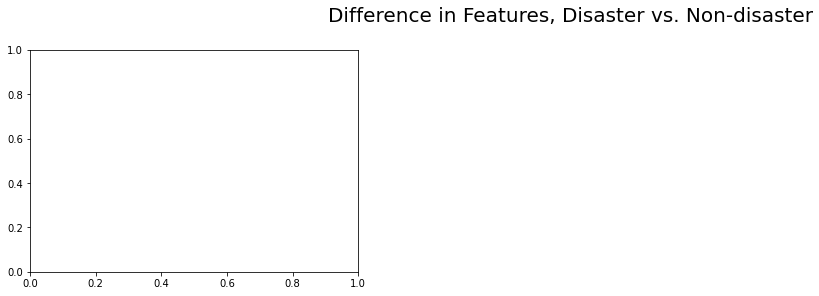

In [15]:
import matplotlib.pyplot as plt

# create the figure
fig = plt.figure(figsize=(20, 20))

# adjust the height of the padding between subplots to avoid overlapping
plt.subplots_adjust(hspace=0.3)

# add a centered suptitle to the figure
plt.suptitle("Difference in Features, Disaster vs. Non-disaster", fontsize=20, y=0.91)

# add a new subplot iteratively
ax = plt.subplot(4, 3, 1)
ax = train[train['keyword_binary']==0]['target'].hist(alpha=0.5, label='Non-disaster', bins=40, color='royalblue', density=True)
ax = train[train['keyword_binary']==1]['target'].hist(alpha=0.5, label='Disaster', bins=40, color='lightcoral', density=True)

# set x_label, y_label, and legend
ax.set_xlabel('keyword', fontsize=14)
ax.set_ylabel('Probability Density', fontsize=14)
ax.legend(loc='upper right', fontsize=14)
    
plt.show()